In [2]:
import os
import geopandas as gpd
import rasterio as rio
import pandas as pd
import numpy as np
from shapely.geometry import Point
import matplotlib.pyplot as plt
# Plot data inline
plt.ion()  #???????????????????
import earthpy as et

# Prettier plotting with seaborn 
import seaborn as sns;
from matplotlib import colors
from scipy import stats
#import elevation

In [3]:
os.chdir(os.path.join(et.io.HOME, 'isd-lite/data_light'))

In [4]:
df=pd.read_csv('stationAttr72.csv')
df.head(),df.shape

(  stationNumber     slope  lowBound  hightBound  slopeInt  pw1972  pw2017
 0  483570-99999 -0.134197 -0.185880   -0.082513        -1   135.0    74.0
 1  722310-12916 -0.083380 -0.148009   -0.018750        -1    78.0   121.0
 2  702710-26425 -0.092815 -0.161811   -0.023820        -1   190.0   157.0
 3  948420-99999 -0.286895 -0.391642   -0.182148        -1   287.0   292.0
 4  943320-99999  0.347579  0.278563    0.416596         1   119.0   131.0,
 (88, 7))

In [5]:
#let's check if there are any NAN's in any of the rows
df.isnull().values.any()

True

In [6]:
#check to see where the null values are
df.isnull().sum()

stationNumber    0
slope            1
lowBound         1
hightBound       1
slopeInt         0
pw1972           0
pw2017           0
dtype: int64

In [7]:
#since there are some null values, we will drop the row(s) with null values
df = df.dropna()
#pandas does not reset index where drop takes place
df.reset_index(drop=True, inplace=True)

df.shape

(87, 7)

In [8]:
#Need to add some attributes from ID_Info.csv
df_id = pd.read_csv("ID_Info.csv")
df_id.head()

,ID,USAF,WBAN,STATION NAME,CTRY,STATE,ICAO,LAT,LON,ELEV(M),BEGIN,END,Timespan
0,008268-99999,8268,99999,WXPOD8278,AF,NaN,NaN,32.950,65.567,1156.7,2010-05-19,2012-03-23,674
1,010010-99999,10010,99999,JAN MAYEN(NOR-NAVY),NO,NaN,ENJA,70.933,-8.667,9.0,1931-01-01,2017-05-22,31553
2,010014-99999,10014,99999,SORSTOKKEN,NO,NaN,ENSO,59.792,5.341,48.8,1986-11-20,2017-05-22,11141
3,010015-99999,10015,99999,BRINGELAND,NO,NaN,NaN,61.383,5.867,327.0,1987-01-17,2011-10-20,9042
4,010016-99999,10016,99999,RORVIK/RYUM,NO,NaN,NaN,64.850,11.233,14.0,1987-01-16,1991-08-06,1663


In [9]:
#add the columns that we will get from ID_Info.csv to df
df["elev"] = np.nan
df["lat"] = np.nan
df["lon"] = np.nan
df.head()

,stationNumber,slope,lowBound,hightBound,slopeInt,pw1972,pw2017,elev,lat,lon
0,483570-99999,-0.134197,-0.185880,-0.082513,-1,135.0,74.0,NaN,NaN,NaN
1,722310-12916,-0.083380,-0.148009,-0.018750,-1,78.0,121.0,NaN,NaN,NaN
2,702710-26425,-0.092815,-0.161811,-0.023820,-1,190.0,157.0,NaN,NaN,NaN
3,948420-99999,-0.286895,-0.391642,-0.182148,-1,287.0,292.0,NaN,NaN,NaN
4,943320-99999,0.347579,0.278563,0.416596,1,119.0,131.0,NaN,NaN,NaN


In [10]:
#fill in the new columns with info from ID_Info.csv
nr = df.shape[0]
for i in range(nr):
    sn = df["stationNumber"][i]
    
    #get the index in df_id associated with that staion number
    idx = df_id.index[df_id['ID']==sn][0]
    
    df.loc[[i],['elev']] = df_id["ELEV(M)"][idx]
    df.loc[[i],['lat']] = df_id["LAT"][idx]
    df.loc[[i],['lon']] = df_id["LON"][idx]

In [11]:
df.head()

,stationNumber,slope,lowBound,hightBound,slopeInt,pw1972,pw2017,elev,lat,lon
0,483570-99999,-0.134197,-0.185880,-0.082513,-1,135.0,74.0,148.0,17.417,104.783
1,722310-12916,-0.083380,-0.148009,-0.018750,-1,78.0,121.0,1.2,29.998,-90.278
2,702710-26425,-0.092815,-0.161811,-0.023820,-1,190.0,157.0,476.1,62.159,-145.459
3,948420-99999,-0.286895,-0.391642,-0.182148,-1,287.0,292.0,83.0,-38.850,143.517
4,943320-99999,0.347579,0.278563,0.416596,1,119.0,131.0,341.7,-20.664,139.489


In [12]:
dfNeg = df[df['slopeInt']== -1]
dfZero = df[df['slopeInt']== 0]
dfPos = df[df['slopeInt']== 1]

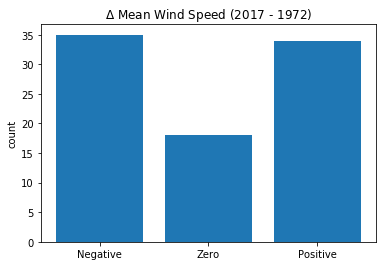

In [13]:
#plot the number of neg,zero,pos trends
x = np.arange(3)
plt.bar(x,[len(dfNeg), len(dfZero), len(dfPos)])
plt.xticks(x,("Negative","Zero", "Positive"));
plt.title("$\Delta$ Mean Wind Speed (2017 - 1972)")
plt.ylabel("count");

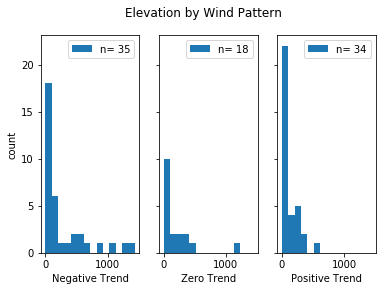

In [14]:
#Look at the elevation by change in wind speed pattern
b = np.linspace(0,max(df.elev),15)
#fig,(ax1,ax2,ax3) = plt.subplots(3,1, sharex = True);
fig,(ax1,ax2,ax3) = plt.subplots(1,3, sharey = True);
ax1.hist(dfNeg["elev"],bins=b,label = "n= "+str(len(dfNeg["elev"])));
ax1.set_ylabel("count")
ax1.set_xlabel("Negative Trend")
ax1.legend()

ax2.hist(dfZero["elev"],bins=b,label = "n= "+str(len(dfZero["elev"])));
ax2.set_xlabel("Zero Trend")
ax2.legend()

ax3.hist(dfPos["elev"],bins = b,label = "n= "+str(len(dfPos["elev"])));
ax3.set_xlabel("Positive Trend")
ax3.legend()

fig.suptitle("Elevation by Wind Pattern");

In [15]:
# are these distributions different? (they don't look it...)
# we use a Kolmogorov-Smirnov test
e1 = dfNeg["elev"]
e2 = dfZero['elev']
e3 = dfPos['elev']
for dist in [e1,e2,e3]:
    for dist2 in [e1,e2,e3]:
        print(stats.ks_2samp(dist,dist2))

Ks_2sampResult(statistic=0.0, pvalue=1.0)
Ks_2sampResult(statistic=0.20158730158730154, pvalue=0.6682378959329579)
Ks_2sampResult(statistic=0.27058823529411763, pvalue=0.13346046176425486)
Ks_2sampResult(statistic=0.20158730158730154, pvalue=0.6682378959329579)
Ks_2sampResult(statistic=0.0, pvalue=1.0)
Ks_2sampResult(statistic=0.2777777777777778, pvalue=0.27518807616285823)
Ks_2sampResult(statistic=0.27058823529411763, pvalue=0.13346046176425486)
Ks_2sampResult(statistic=0.2777777777777778, pvalue=0.27518807616285823)
Ks_2sampResult(statistic=0.0, pvalue=1.0)


## Now let's look at the points on a map!

In [16]:
f

#we need to add a string column that represents slopeInt for better
#plotting
def createString(gdf):
    if gdf["slopeInt"] == -1:
        return "Negative"
    elif gdf["slopeInt"] ==0:
        return "Zero"
    elif gdf["slopeInt"]==1:
        return "Positive"
    else:
        return "Big trouble in little china!"
gdf['trend'] = gdf.apply(createString, axis = 1)

In [23]:
gdf.head()

,stationNumber,slope,lowBound,hightBound,slopeInt,pw1972,pw2017,elev,lat,lon,coordinates,trend
0,483570-99999,-0.134197,-0.185880,-0.082513,-1,135.0,74.0,148.0,17.417,104.783,POINT (104.783 17.417),Negative
1,722310-12916,-0.083380,-0.148009,-0.018750,-1,78.0,121.0,1.2,29.998,-90.278,POINT (-90.27800000000001 29.998),Negative
2,702710-26425,-0.092815,-0.161811,-0.023820,-1,190.0,157.0,476.1,62.159,-145.459,POINT (-145.459 62.159),Negative
3,948420-99999,-0.286895,-0.391642,-0.182148,-1,287.0,292.0,83.0,-38.850,143.517,POINT (143.517 -38.85),Negative
4,943320-99999,0.347579,0.278563,0.416596,1,119.0,131.0,341.7,-20.664,139.489,POINT (139.489 -20.664),Positive


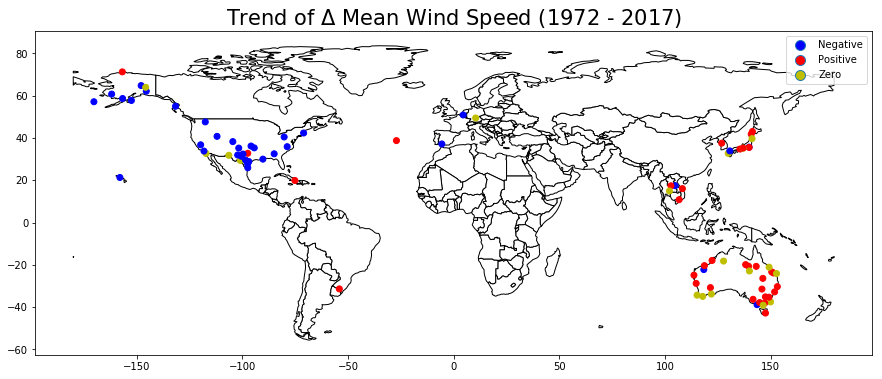

In [19]:
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
world = world[world.name!="Antarctica"]
colorList = ['b','r','y']
fig, ax = plt.subplots(figsize = (15,15));
world.plot(color = 'white',
           edgecolor = 'black',
           ax = ax)
gdf.plot(ax = ax,
         column='trend',
         cmap =colors.ListedColormap(colorList),
         legend = True);
ax.set_title("Trend of $\Delta$ Mean Wind Speed (1972 - 2017)", fontsize = 21);


# now lets make a cusom legend to make plot better
 Plot by Attribute
To plot a vector layer by attribute value so each road layer is colored according to it’s respective attribute value, and so the legend also represents that same symbology you need to do three things.

1. You need to create a dictionary that associates a particular color with a particular attribute value
2. You then need to loop through and apply that color to each attribute value
3. Finally you need to add a label argument to your plot so you can call ax.legend() to make your final legend.

In [20]:
# Create a dictionary where you assign each attribute value to a particular color
trendPalette = {"Negative": 'b',
               "Positive": 'r',
               "Zero": 'grey'}

Next, you loop through each attribute value and plot the lines with that attribute value using the color specified in the dictionary. To ensure your legend generates properly, you add a label= argument to your plot call. The label value will be the attribute value that you used to plot. Below that value is defined by the ctype variable.

Then you can call ax.legend() to create a legend.

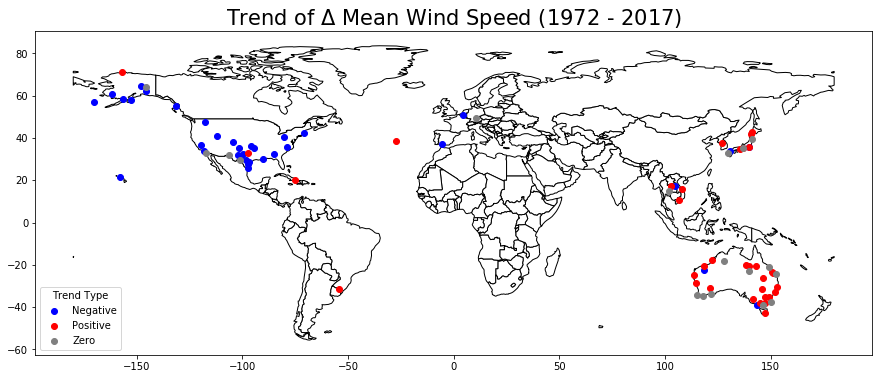

In [21]:
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
world = world[world.name!="Antarctica"]
#plot the data
fig,ax = plt.subplots(figsize=(15,15))
world.plot(color = 'white',
           edgecolor = 'black',
           ax = ax)

#loop through each attribute type and plot it using the colors assigned to the dictionary
for ctype, data in gdf.groupby("trend"):
    color = trendPalette[ctype]
    data.plot(color = color,
              ax = ax,
              label = ctype)
ax.legend(title = "Trend Type",
          loc = "lower left");
ax.set_title("Trend of $\Delta$ Mean Wind Speed (1972 - 2017)", fontsize = 21);

In [25]:
gdf.head(1)

,stationNumber,slope,lowBound,hightBound,slopeInt,pw1972,pw2017,elev,lat,lon,coordinates,trend
0,483570-99999,-0.134197,-0.18588,-0.082513,-1,135.0,74.0,148.0,17.417,104.783,POINT (104.783 17.417),Negative


In [24]:
for index,row in gdf.iterrows():
    print(index)
    print(row)
    break

0
stationNumber              483570-99999
slope                         -0.134197
lowBound                       -0.18588
hightBound                   -0.0825134
slopeInt                             -1
pw1972                              135
pw2017                               74
elev                                148
lat                              17.417
lon                             104.783
coordinates      POINT (104.783 17.417)
trend                          Negative
Name: 0, dtype: object


In [26]:
world.head()

,pop_est,continent,name,iso_a3,gdp_md_est,geometry
0,28400000.0,Asia,Afghanistan,AFG,22270.0,"POLYGON ((61.21081709172574 35.65007233330923,..."
1,12799293.0,Africa,Angola,AGO,110300.0,(POLYGON ((16.32652835456705 -5.87747039146621...
2,3639453.0,Europe,Albania,ALB,21810.0,"POLYGON ((20.59024743010491 41.85540416113361,..."
3,4798491.0,Asia,United Arab Emirates,ARE,184300.0,"POLYGON ((51.57951867046327 24.24549713795111,..."
4,40913584.0,South America,Argentina,ARG,573900.0,(POLYGON ((-65.50000000000003 -55.199999999999...


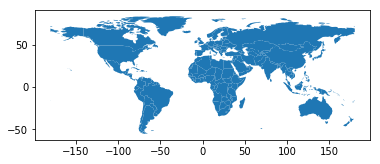

In [27]:
world.plot()

In [28]:
world.crs

{'init': 'epsg:4326'}

In [29]:
gdf.crs

In [91]:
srtmLookup = pd.read_csv(os.path.join(et.io.HOME, 'scratch/SRTM/dds.cr.usgs.gov/srtm/version2_1/SRTM30/SRTM_lookup.csv'))

In [93]:
srtmLookup = srtmLookup.drop(['Unnamed: 0'], axis = 1)

In [97]:
srtmLookup.head()

,title,minLat,maxLat,minLon,maxLon,minElev,maxElev,mean,std
0,w180n90,40,90,-180,-140,-6,6098,67,246
1,w140n90,40,90,-140,-100,-71,4635,378,563
2,w100n90,40,90,-100,-60,-18,2416,185,267
3,w060n90,40,90,-60,-20,-14,3940,520,924
4,w020n90,40,90,-20,20,-179,4536,93,266


In [140]:
#function to lookup srtm .tiff name
lat = 17.417
lon = 104.783
def srtmLookupFun(srtmLookup,lat,lon):
    s = srtmLookup[(srtmLookup["minLat"]<lat) & (srtmLookup["maxLat"]>lat) & (srtmLookup["minLon"]<lon) & (srtmLookup["maxLon"]>lon)]
    return s['title'].astype(str).values[0]

In [143]:
h = srtmLookupFun(srtmLookup,lat,lon)
h

'e100n40'

In [157]:
for index,row in gdf.iterrows():
    lat = row["lat"]
    lon = row["lon"]
    srtmTitle = srtmLookupFun(srtmLookup, lat,lon)
    print(srtmTitle)
    path = os.path.join(et.io.HOME,"scratch/SRTM/dds.cr.usgs.gov/srtm/version2_1/SRTM30/e020n40/E020N40.hgt")
    print(path)
    with rio.open(path)as src:
        lidar_dem_im = src.read(1)
    break

e100n40
/users/a/a/aametcal/scratch/SRTM/dds.cr.usgs.gov/srtm/version2_1/SRTM30/e020n40/E020N40.hgt


RasterioIOError: '/users/a/a/aametcal/scratch/SRTM/dds.cr.usgs.gov/srtm/version2_1/SRTM30/e020n40/E020N40.hgt' not recognized as a supported file format.